##### Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os

from functions.temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context = "notebook", style = "ticks", font="verdana") # font_scale = 1.35)

In [2]:
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Paths

In [3]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/")

In [4]:
path_shiny_mouse = os.path.join(csv_path, "current_shiny_mouse.csv")
path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")

##### Start Code

In [5]:
fields_shiny = ["cell_name", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label"]

In [6]:
shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA amp Pass/Fail",
              "marker_sum_norm_label": "NMS score",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)"}

In [7]:
shiny_mouse = read_file(path_shiny_mouse, fields_shiny) #10839 rows
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows

INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe


In [8]:
shiny_mouse.rename(columns=shiny_dict, inplace=True)
shiny_human.rename(columns=shiny_dict, inplace=True)

In [9]:
shiny_mouse.dropna(subset=["cell_specimen_project"],inplace=True) #10834 rows
shiny_human.dropna(subset=["cell_specimen_project"],inplace=True) #3578 rows

##### Filter project code

In [10]:
shinym = filter_df(shiny_mouse, "cell_specimen_project", "mIVSCC-MET") 
shinyh = filter_df(shiny_human, "cell_specimen_project", "hIVSCC-MET")
shinym = create_container_df(shinym, "sample_id")
shinyh = create_container_df(shinyh, "sample_id")

INFO:functions.temp_funcs:Filtered dataframe based on cell_specimen_project == mIVSCC-MET
INFO:functions.temp_funcs:Filtered dataframe based on cell_specimen_project == hIVSCC-MET
C:\Users\kumar\Documents\Github\analysis_projects\analysis_scripts\functions\temp_funcs.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["collaborator_label"] = df[container_col].str[0:2]


In [11]:
shinym.dropna(subset=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"], inplace=True)
shinym = shinym[shinym["cDNA quality (%>400 bp)"] <=1]
shinym = shinym[shinym["Amplified content (ng)"] <=50]
shinym = filter_df(shinym, "NMS Pass/Fail", True)
#shinym_rpass = filter_df(shinym, "RNA amp Pass/Fail", "Pass")
shinym = filter_df(shinym, "RNA amp Pass/Fail", "Fail")

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == True
INFO:functions.temp_funcs:Filtered dataframe based on RNA amp Pass/Fail == Fail


In [12]:
shinyh.dropna(subset=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"], inplace=True)
shinyh = shinyh[shinyh["cDNA quality (%>400 bp)"] <=1]
shinyh = shinyh[shinyh["Amplified content (ng)"] <=50]
shinyh = filter_df(shinyh, "NMS Pass/Fail", True)
shinyh = filter_df(shinyh, "RNA amp Pass/Fail", "Fail")

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == True
INFO:functions.temp_funcs:Filtered dataframe based on RNA amp Pass/Fail == Fail


In [13]:
collaborator_dict = {"PG" : "Gabor", "PH" : "Mansvelder"}
for collab in ["P1", "P2", "P6", "P7", "P8", "P9", "PA", "PB", "PE", "PX"]:
    collaborator_dict[collab] = "AIBS"

shinyh["collaborator_label"] = shinyh["collaborator_label"].replace(collaborator_dict)

##### Merging mouse and human shiny df

In [14]:
shiny = pd.concat([shinym, shinyh], ignore_index=True, sort =False) #8593
shiny = shiny[shiny["cDNA quality (%>400 bp)"] <=1] #1577
shiny = shiny[shiny["Amplified content (ng)"] <=50] #1550

##### Counts

In [15]:
aibs = filter_df(shinyh, "collaborator_label", "AIBS")
pg = filter_df(shinyh, "collaborator_label", "Gabor")
ph = filter_df(shinyh, "collaborator_label", "Mansvelder")
print(f"Mouse Human total count: {shiny.sample_id.count()}")
print(f"Mouse total count: {shinym.sample_id.count()}")
print(f"Human total count: {shinyh.sample_id.count()}")
print(f"AIBS count: {aibs.sample_id.count()}")
print(f"Gabor count: {pg.sample_id.count()}")
print(f"Mansvelder count: {ph.sample_id.count()}")

INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == AIBS
INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == Gabor
INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == Mansvelder


Mouse Human total count: 646
Mouse total count: 566
Human total count: 80
AIBS count: 64
Gabor count: 14
Mansvelder count: 2


##### Plots

In [34]:
core = shinyh[shinyh["Tree_call"] == "PoorQ"]
core

,sample_id,cell_name,cDNA quality (%>400 bp),RNA amp Pass/Fail,Amplified content (ng),cell_specimen_project,NMS score,NMS Pass/Fail,seurat_prediction_score_label,Tree_call,collaborator_label
149,PBS4_171219_501_A01,H17.03.016.11.03.01,0.397,Fail,7.926456,hIVSCC-MET,0.661915,True,0.933113,PoorQ,AIBS
673,PGS4_180919_803_A01,H18.28.025.11.08.01,0.364,Fail,9.094264,hIVSCC-MET,0.545243,True,0.527092,PoorQ,Gabor
1406,P2S4_171016_054_A01,H17.06.013.12.05.02,0.175,Fail,29.782144,hIVSCC-MET,0.560409,True,0.746188,PoorQ,AIBS
1691,PGS4_180613_803_A01,H18.28.020.11.06.01,0.411,Fail,6.824818,hIVSCC-MET,0.719519,True,0.379425,PoorQ,Gabor
1716,PBS4_180326_509_A01,H18.06.005.11.06.09,0.390,Fail,5.996116,hIVSCC-MET,0.452606,True,0.590819,PoorQ,AIBS
1717,P2S4_180417_052_A01,H18.03.008.11.06.02,0.273,Fail,6.373714,hIVSCC-MET,0.474713,True,0.408375,PoorQ,AIBS
1719,PGS4_180919_701_A01,H18.28.025.11.05.01,0.361,Fail,6.346713,hIVSCC-MET,0.517821,True,0.285102,PoorQ,Gabor
1771,P9S4_180508_414_A01,H18.03.010.11.10.10,0.409,Fail,20.896897,hIVSCC-MET,0.593945,True,0.383757,PoorQ,AIBS
1797,P2S4_180417_051_A01,H18.03.008.11.06.01,0.233,Fail,8.389378,hIVSCC-MET,0.695001,True,0.974101,PoorQ,AIBS
1825,P9S4_180717_408_A01,H18.26.405.12.05.01.01,0.168,Fail,22.441450,hIVSCC-MET,0.435711,True,0.609205,PoorQ,AIBS


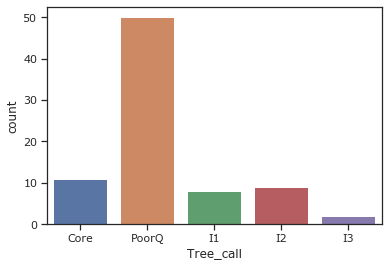

In [27]:
sns.countplot(x="Tree_call", data=shinyh)

In [16]:
spec_colors= {"mIVSCC-MET" : "#ef3b2c", "hIVSCC-MET" : "#4292c6"}
#human_colors = {"AIBS":"#c6dbef", "Gabor":"#6baed6", "Mansvelder":"#2171b5"}
human_colors = {"AIBS":"#6baed6", "Gabor":"#2171b5", "Mansvelder":"#08306b"}

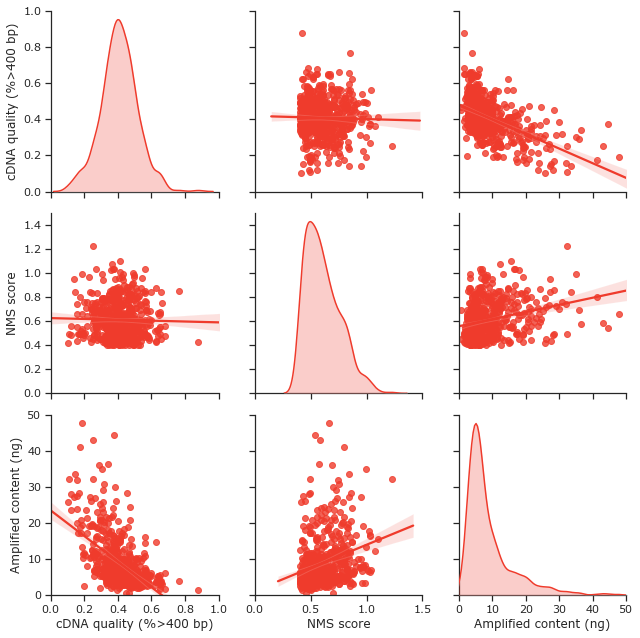

In [17]:
ax = sns.pairplot(data=shinym, vars=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"],
                  height=3, aspect=1, diag_kind="kde", hue="cell_specimen_project", palette=spec_colors, kind="reg")
ax._legend.remove()
ax.axes[0,0].set_xlim((0,1))
ax.axes[0,1].set_xlim((0,1.5))
ax.axes[0,2].set_xlim((0,50))
ax.axes[0,2].set_ylim((0,1))
ax.axes[1,2].set_ylim((0,1.5))
ax.axes[2,2].set_ylim((0,50))

plt.savefig(plot_path + "mouse_pairplot_nms_pass_rna_fail.jpeg", bbox_inches="tight")

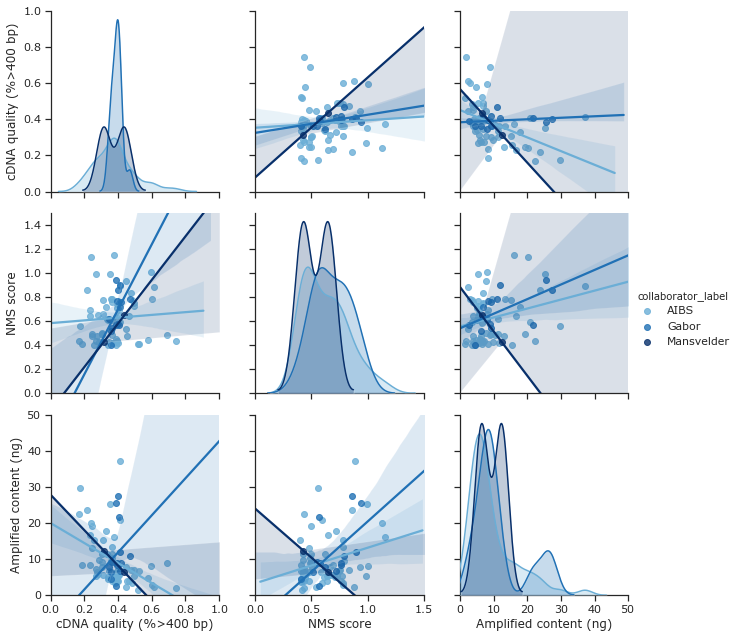

In [18]:
ax = sns.pairplot(data=shinyh, vars=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"],
                  height=3, diag_kind="kde", hue="collaborator_label", palette=human_colors, kind="reg")

ax.axes[0,0].set_xlim((0,1))
ax.axes[0,1].set_xlim((0,1.5))
ax.axes[0,2].set_xlim((0,50))
ax.axes[0,2].set_ylim((0,1))
ax.axes[1,2].set_ylim((0,1.5))
ax.axes[2,2].set_ylim((0,50))

plt.savefig(plot_path + "human_pairplot_nms_pass_rna_fail.jpeg", bbox_inches="tight")

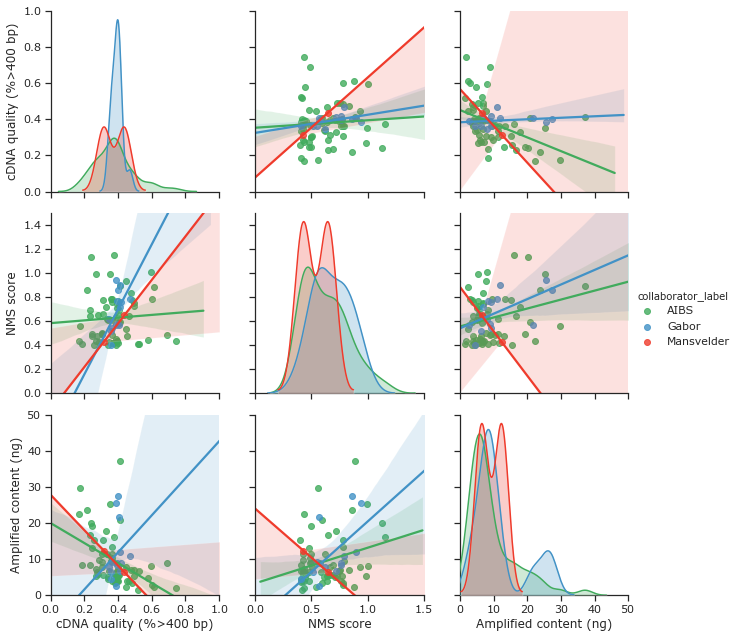

In [19]:
human_colors = {"AIBS":"#41ab5d", "Gabor":"#4292c6", "Mansvelder":"#ef3b2c"}
ax = sns.pairplot(data=shinyh, vars=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"],
                  height=3, diag_kind="kde", hue="collaborator_label", palette=human_colors, kind="reg")

ax.axes[0,0].set_xlim((0,1))
ax.axes[0,1].set_xlim((0,1.5))
ax.axes[0,2].set_xlim((0,50))
ax.axes[0,2].set_ylim((0,1))
ax.axes[1,2].set_ylim((0,1.5))
ax.axes[2,2].set_ylim((0,50))

plt.savefig(plot_path + "human_pairplot_nms_pass_rna_fail.jpeg", bbox_inches="tight")

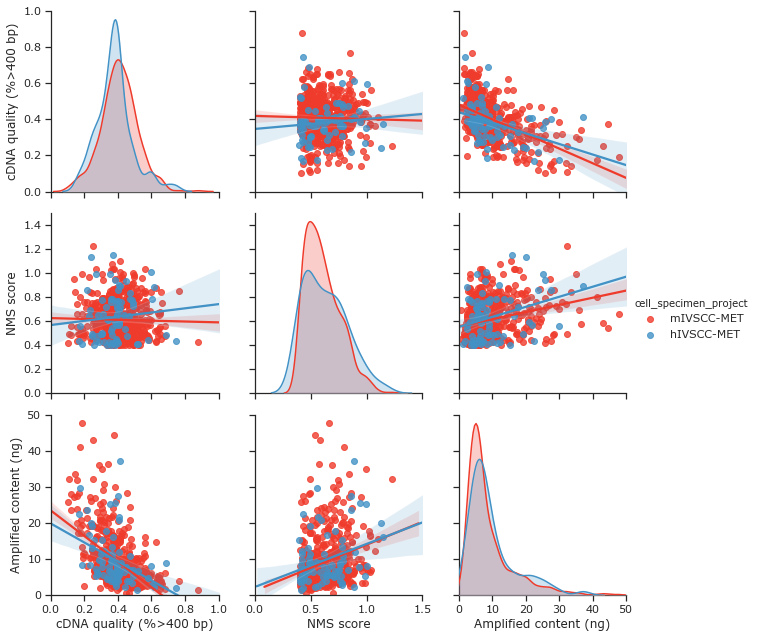

In [20]:
ax = sns.pairplot(data=shiny, vars=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"],
                  height=3, diag_kind="kde", hue="cell_specimen_project", palette=spec_colors, kind="reg")

ax.axes[0,0].set_xlim((0,1))
ax.axes[0,1].set_xlim((0,1.5))
ax.axes[0,2].set_xlim((0,50))
ax.axes[0,2].set_ylim((0,1))
ax.axes[1,2].set_ylim((0,1.5))
ax.axes[2,2].set_ylim((0,50))

plt.savefig(plot_path + "mouse_human_pairplot_nms_pass_rna_fail.jpeg", bbox_inches="tight")

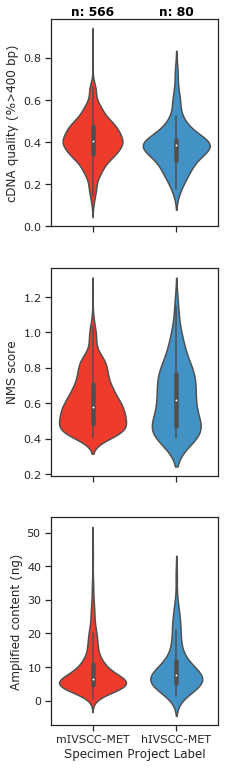

In [21]:
fig_dims = (3, 13)
f, axes = plt.subplots(nrows=3, ncols=1, figsize=fig_dims)

ax = sns.violinplot(x="cell_specimen_project", y="cDNA quality (%>400 bp)", data=shiny[shiny["cDNA quality (%>400 bp)"] <=1], 
                    order=["mIVSCC-MET", "hIVSCC-MET"], inner="box", scale="area",
                    palette=spec_colors, saturation=1, ax=axes[0])
ax1 = sns.violinplot(x="cell_specimen_project", y="NMS score", data=shiny[shiny["NMS score"] <=1.5],
                     order=["mIVSCC-MET", "hIVSCC-MET"], inner="box", scale="area",
                     palette=spec_colors, saturation=1, ax=axes[1])
ax2 = sns.violinplot(x="cell_specimen_project", y="Amplified content (ng)",
                     data=shiny[shiny["Amplified content (ng)"] <=50],
                     order=["mIVSCC-MET", "hIVSCC-MET"], inner="box", scale="area",
                     palette=spec_colors, saturation=1, ax=axes[2])

ax.set(xticklabels=[])
ax1.set(xticklabels=[])

ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("Specimen Project Label")

nobs = shiny["cell_specimen_project"].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1, nobs[tick], horizontalalignment='center', size="large", color='black', weight='bold')
    
plt.savefig(plot_path + "violinplot_nms_pass_rna_fail.jpeg", bbox_inches="tight")

In [22]:
def single_vio_plt(col_y, lim_y, plot_name):
    fig_dims = (3, 4)
    f, axes = plt.subplots(figsize=fig_dims)

    ax = sns.violinplot(x="cell_specimen_project", y=col_y, data=shiny[shiny[col_y] <= lim_y], 
                        order=["mIVSCC-MET", "hIVSCC-MET"], inner="box", scale="area",
                        palette=spec_colors, saturation=1)
    plt.savefig(plot_path + "violinplot_nms_pass_rna_fail_" + plot_name + ".jpeg", bbox_inches="tight")

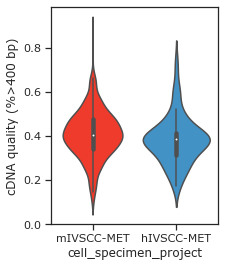

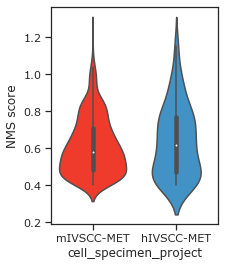

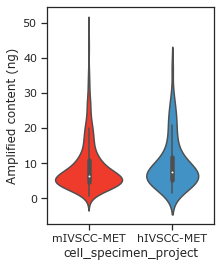

In [23]:
single_vio_plt("cDNA quality (%>400 bp)", 1, "cdna")
single_vio_plt("NMS score", 1.5, "nms")
single_vio_plt("Amplified content (ng)", 50, "amp")